In [1]:
#from IPython.core.display import clear_output

#!pip3 install pandas-profiling==2.11
#clear_output()

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#! cp /content/drive/MyDrive/semester7/Thesis/Models/* ./ -r
#! cp /content/drive/MyDrive/semester7/Thesis/Datasets/* ./ -r

In [3]:
#!gdown 1YHqgEFHoXa5vpSfKteAhBUWsJJ2RHgS7 -O data.csv

In [4]:
cd ..

D:\Учеба\7 semester\Model_stage5_after_session _stage3


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
#from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale

from Datasets.ProcessDataset import Dataset

#import torch
from sklearn.model_selection import train_test_split

from Models.Optimisers.GD import StochasticGradientDescent
from Models.Optimisers.Adam import Adam

from Models.Preconditioners.Preconditioners import SGD_preconditioner,Adam_preconditioner,OASIS_preconditioner

#from Models.LogisticRegression.LogisticRegression import Logistic_Regression
#from Models.LogisticRegression.LogisticRegression_layer import Logistic_Regression_train
from Models.LogisticRegression.LogisticRegression_numpy import Logistic_Regression_numpy
from Models.LogisticRegression.LogisticRegression_sklearn import Logistic_Regression_origin

from Models.FederatedLearning.Server import server
from Models.FederatedLearning.Worker import worker

from Models.MatrixScheduler.MatrixScheduler_identical import MatrixScheduler_identical
from Models.MatrixScheduler.MatrixScheduler_Uniform import MatrixScheduler_Uniform,CommonMatrixScheduler_Uniform

from Models.StatisticClass import Statistic
from Models.StatisticClass import comparsion_array_loss,comparsion_array_weights,comparsion_array_acc

from Models.StatisticClass import loss_array_mean_plot,acc_array_mean_plot
from Models.StatisticClass import comparison_loss_array_mean_plot,comparison_acc_array_mean_plot

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression


from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [6]:
import random
random.seed(42)

# load Dataset

In [7]:
data = Dataset(dataset_name = 'Titanic')
X,y = data.X,data.y

In [8]:
cd D:\Учеба\7 semester\Models_paper\Reports\2Preconditioner

D:\Учеба\7 semester\Model_stage5_after_session _stage3\Reports


# Classification Model

In [9]:
#X = d_class
#y = y_class
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#X_train,y_train,X_test,y_test = torch.tensor(X_train),torch.tensor(y_train),torch.tensor(X_test),torch.tensor(y_test)

# Federated learning

In [10]:
LR_EPOCH = {"lr":1e-2,"epoch":1000}

In [11]:
#M_NAMES = ["Logistic_Regression_train", "Logistic_Regression","Logistic_Regression_numpy"]
M_NAMES = "Logistic_Regression_numpy"

In [12]:
LR_EPOCH = {'lr': 0.01, 'epoch': 1000}

In [13]:
model_name = M_NAMES#[2]
model_params = {"lr":LR_EPOCH['lr']}
model_name, model_params

('Logistic_Regression_numpy', {'lr': 0.01})

## Example 2 identical

In [14]:
def show_data_stat(current_stat):
    #current_stat = federated_sch_u_stat_collectors[0]
    current_stat[0].loss_plot()
    current_stat[1].loss_plot()
    current_stat[2].loss_plot()

    current_stat[0].print_accuracy()
    current_stat[1].print_accuracy()
    current_stat[2].print_accuracy()
    
    print(current_stat[0].data_description)
    print(current_stat[1].data_description)
    print(current_stat[2].data_description)
    
    loss_array_mean_plot(current_stat)
    acc_array_mean_plot(current_stat)
    
    

    
def show_data_stat_comparison(current_stat_collector1,current_stat_collector2):
    print(current_stat_collector1[0].lable)
    current_stat_collector1[0].print_accuracy()
    
    print(current_stat_collector1[1].lable)
    current_stat_collector1[1].print_accuracy()
    
    print(current_stat_collector1[2].lable)
    current_stat_collector1[2].print_accuracy()


    print(current_stat_collector2[0].lable)
    current_stat_collector2[0].print_accuracy()
    
    print(current_stat_collector2[1].lable)
    current_stat_collector2[1].print_accuracy()
    
    print(current_stat_collector2[2].lable)
    current_stat_collector2[2].print_accuracy()
    
    comparison_loss_array_mean_plot(current_stat_collector1,current_stat_collector2)
    comparison_acc_array_mean_plot(current_stat_collector1,current_stat_collector2)

### Federated, preconditioner: SGD

#### Scheduler: identity

In [15]:
#SGD
model_params = {"lr":LR_EPOCH['lr']}

precond = [SGD_preconditioner(),SGD_preconditioner(),SGD_preconditioner()]

federated_is_stat_collectors = [Statistic(X_test,y_test,"worker1_ident_sgd"),
                                Statistic(X_test,y_test,"worker2_ident_sgd"),
                                Statistic(X_test,y_test,"worker3_ident_sgd")]

models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[0],
                                       epoch = 1,stat_collector=federated_is_stat_collectors[0]),
         Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[1],
                                       epoch = 1,stat_collector=federated_is_stat_collectors[1]),
         Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[2],
                                       epoch = 1,stat_collector=federated_is_stat_collectors[2])]

scheduler = [MatrixScheduler_identical(),MatrixScheduler_identical(),MatrixScheduler_identical()]

s = server(M_workers=3,
           X_train = X_train,y_train = y_train,
           stat_collectors = federated_is_stat_collectors,
           models = models,
           data_splitter = 'id',m_scheduler = scheduler)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

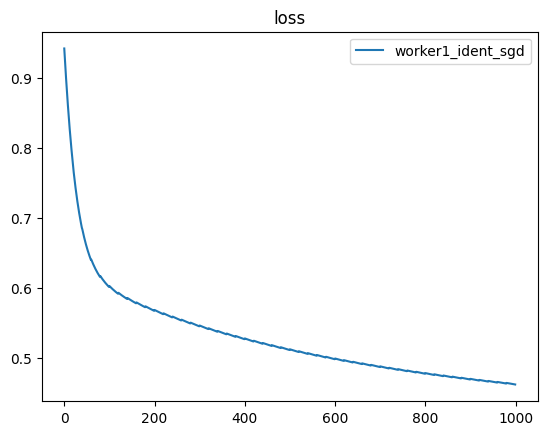

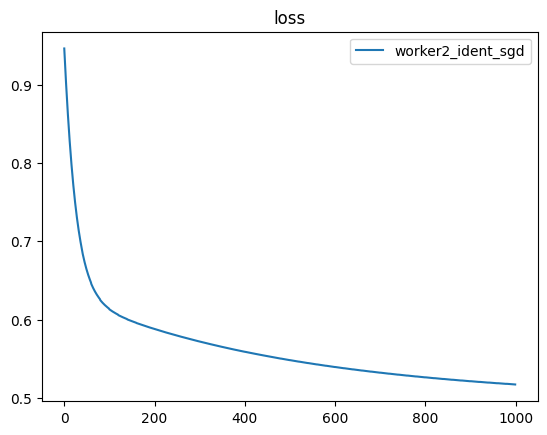

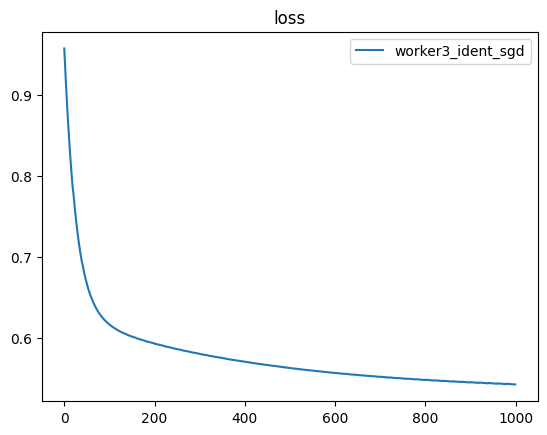

balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
balanced_accuracy_score: 0.7170385395537525
accuracy_score: 0.7482517482517482
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


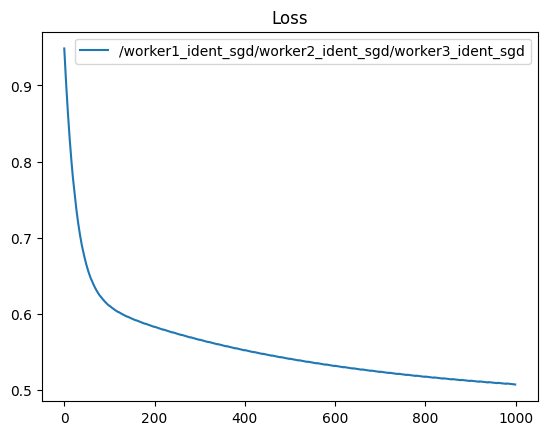

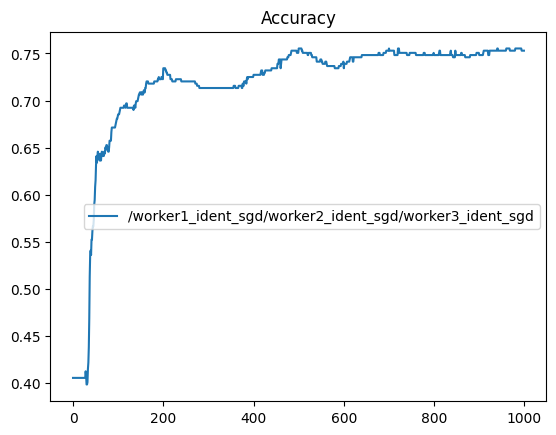

In [16]:
show_data_stat(federated_is_stat_collectors)

#### Scheduler: uniform

In [17]:
#SGD
model_params = {"lr":LR_EPOCH['lr']}

precond = [SGD_preconditioner(),SGD_preconditioner(),SGD_preconditioner()]

federated_us_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_sgd"),
                                Statistic(X_test,y_test,"worker2_uniform_sgd"),
                                Statistic(X_test,y_test,"worker3_uniform_sgd")]

models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[0],
                                       epoch = 1,stat_collector=federated_us_stat_collectors[0]),
          Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[1],
                                       epoch = 1,stat_collector=federated_us_stat_collectors[1]),
          Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[2],
                                       epoch = 1,stat_collector=federated_us_stat_collectors[2])]

scheduler = CommonMatrixScheduler_Uniform(alpha=0.01,gamma=3,
                                      change_mode=CommonMatrixScheduler_Uniform.change_on_each_global_update,n_workers = 3)

schedulers = [scheduler, scheduler, scheduler]

s = server(M_workers=3,
           X_train = X_train,y_train = y_train,
           stat_collectors = federated_us_stat_collectors,
           models = models,
           data_splitter = 'id',m_scheduler = schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

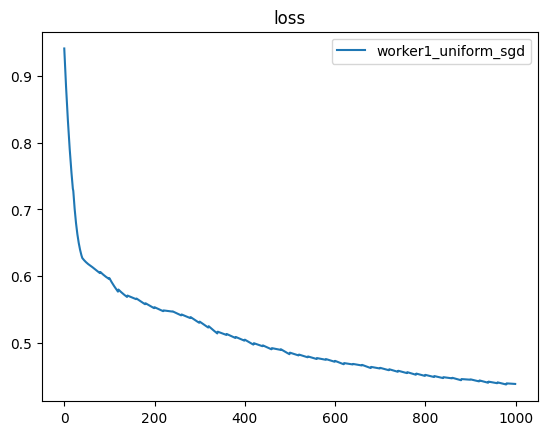

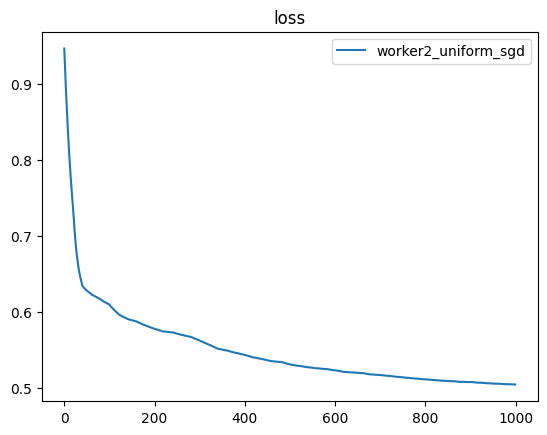

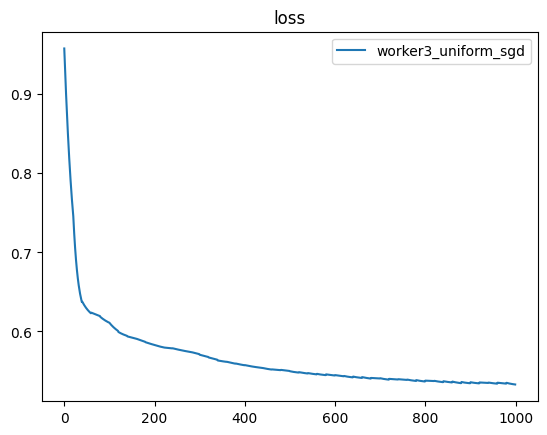

balanced_accuracy_score: 0.7565922920892495
accuracy_score: 0.7692307692307693
balanced_accuracy_score: 0.7565922920892495
accuracy_score: 0.7692307692307693
balanced_accuracy_score: 0.7370182555780933
accuracy_score: 0.7622377622377622
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


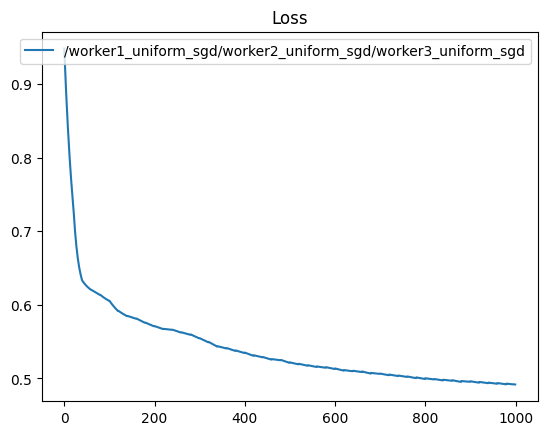

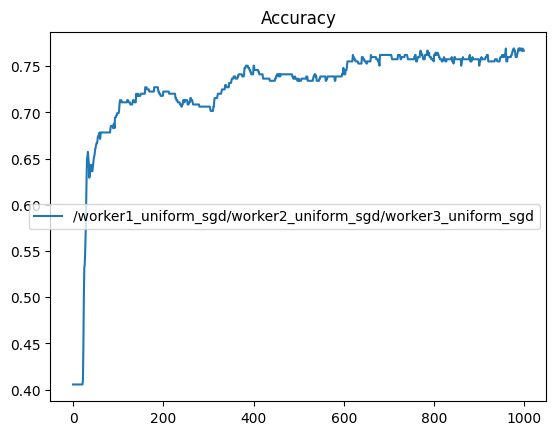

In [18]:
show_data_stat(federated_us_stat_collectors)

#### сравнение: Scheduler: uniform,Scheduler: identical

worker1_ident_sgd
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
worker2_ident_sgd
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
worker3_ident_sgd
balanced_accuracy_score: 0.7170385395537525
accuracy_score: 0.7482517482517482
worker1_uniform_sgd
balanced_accuracy_score: 0.7565922920892495
accuracy_score: 0.7692307692307693
worker2_uniform_sgd
balanced_accuracy_score: 0.7565922920892495
accuracy_score: 0.7692307692307693
worker3_uniform_sgd
balanced_accuracy_score: 0.7370182555780933
accuracy_score: 0.7622377622377622


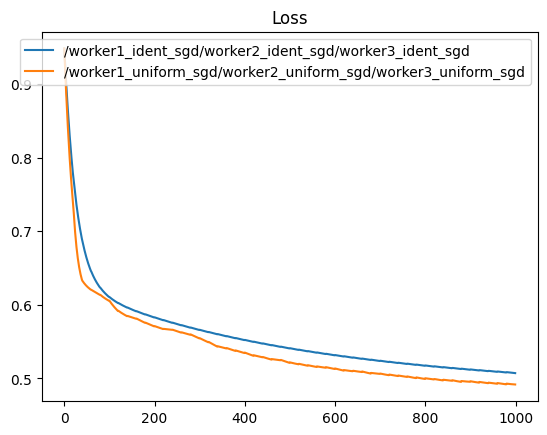

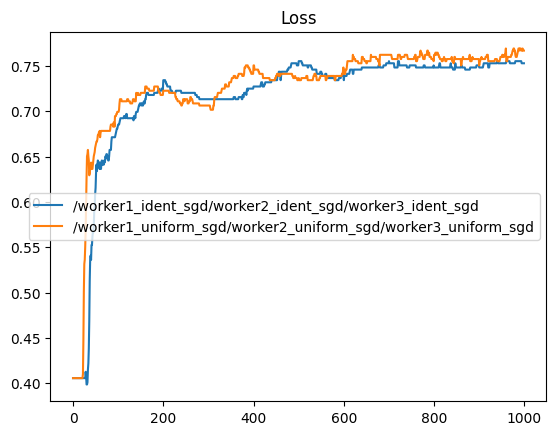

In [19]:
show_data_stat_comparison(federated_is_stat_collectors,federated_us_stat_collectors)

### Federated, preconditioner: Adam

#### Scheduler: identity

In [20]:
#Adam
model_params = {"lr":LR_EPOCH['lr']}

precond = [Adam_preconditioner(beta2 = 0.4),
           Adam_preconditioner(beta2 = 0.4),
           Adam_preconditioner(beta2 = 0.4)]

federated_ia_stat_collectors = [Statistic(X_test,y_test,"worker1_ident_adam"),
                                Statistic(X_test,y_test,"worker2_ident_adam"),
                                Statistic(X_test,y_test,"worker3_ident_adam")]

models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[0],
                                       epoch = 1,stat_collector=federated_ia_stat_collectors[0]),
         Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[1],
                                       epoch = 1,stat_collector=federated_ia_stat_collectors[1]),
         Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[2],
                                       epoch = 1,stat_collector=federated_ia_stat_collectors[2])]

scheduler = [MatrixScheduler_identical(),MatrixScheduler_identical(),MatrixScheduler_identical()]

s = server(M_workers=3,
           X_train = X_train,y_train = y_train,
           stat_collectors = federated_ia_stat_collectors,
           models = models,
           data_splitter = 'id',m_scheduler = scheduler)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

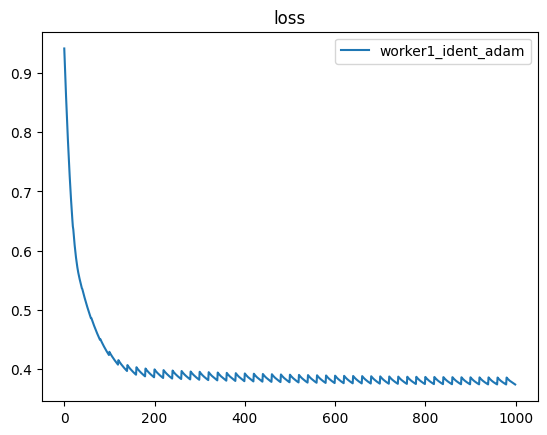

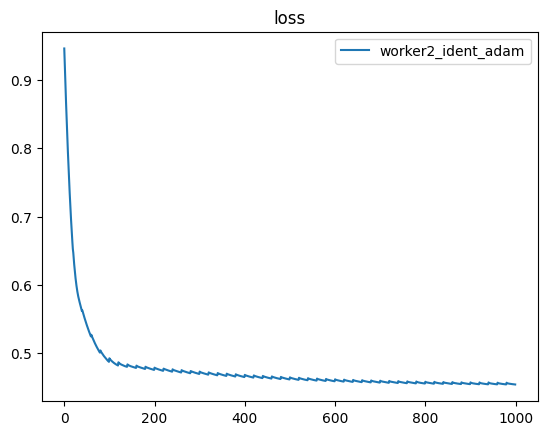

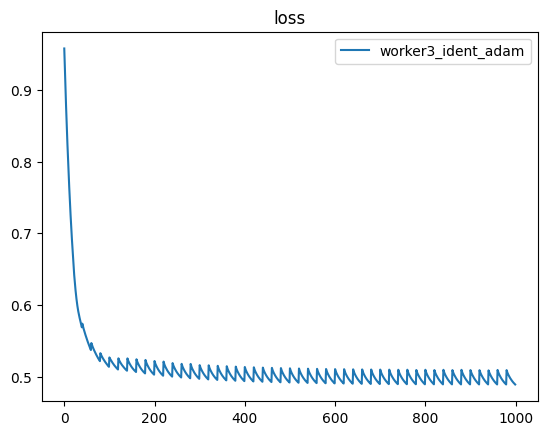

balanced_accuracy_score: 0.7855983772819473
accuracy_score: 0.7972027972027972
balanced_accuracy_score: 0.7710953346855984
accuracy_score: 0.7832167832167832
balanced_accuracy_score: 0.7134888438133874
accuracy_score: 0.7342657342657343
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


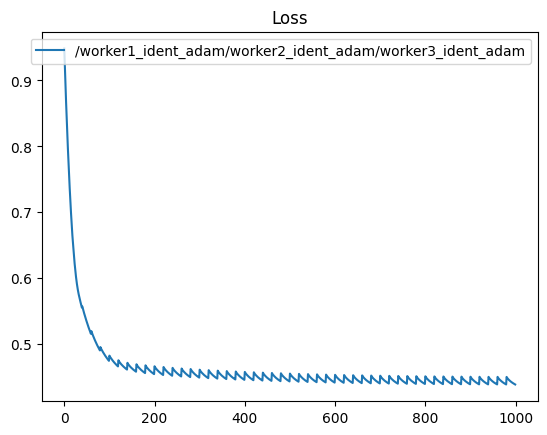

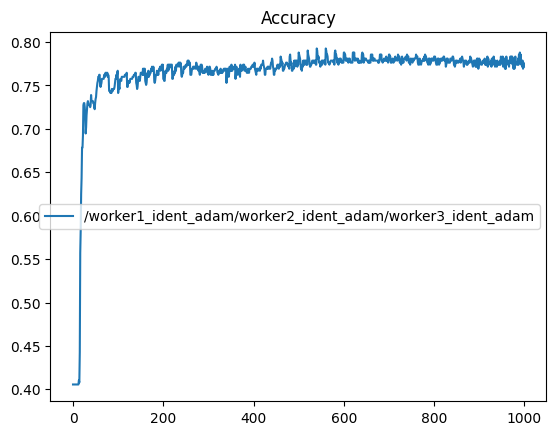

In [21]:
show_data_stat(federated_ia_stat_collectors)

#### Scheduler: uniform

In [22]:
#SGD
model_params = {"lr":LR_EPOCH['lr']}

precond = [Adam_preconditioner(beta2 = 0.4),
           Adam_preconditioner(beta2 = 0.4),
           Adam_preconditioner(beta2 = 0.4)]

federated_ua_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_adam"),
                                Statistic(X_test,y_test,"worker2_uniform_adam"),
                                Statistic(X_test,y_test,"worker3_uniform_adam")]

models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[0],
                                       epoch = 1,stat_collector=federated_ua_stat_collectors[0]),
          Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[1],
                                       epoch = 1,stat_collector=federated_ua_stat_collectors[1]),
          Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[2],
                                       epoch = 1,stat_collector=federated_ua_stat_collectors[2])]

scheduler = CommonMatrixScheduler_Uniform(alpha=0.01,gamma=3,
                                      change_mode=CommonMatrixScheduler_Uniform.change_on_each_global_update,n_workers = 3)

schedulers = [scheduler, scheduler, scheduler]

s = server(M_workers=3,
           X_train = X_train,y_train = y_train,
           stat_collectors = federated_ua_stat_collectors,
           models = models,
           data_splitter = 'id',m_scheduler = schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

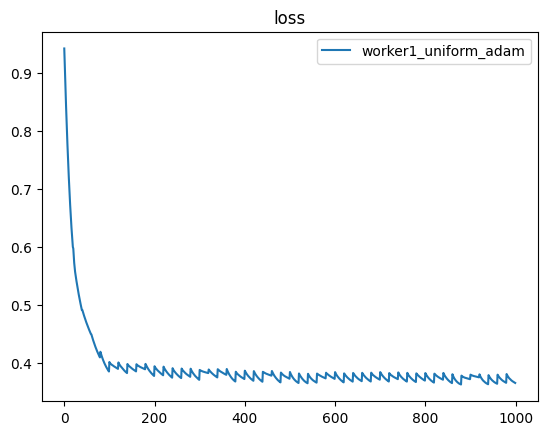

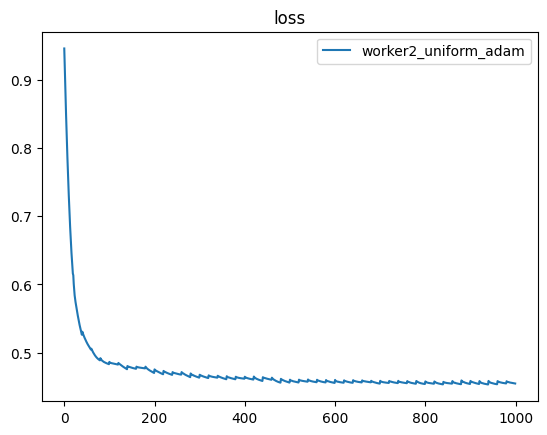

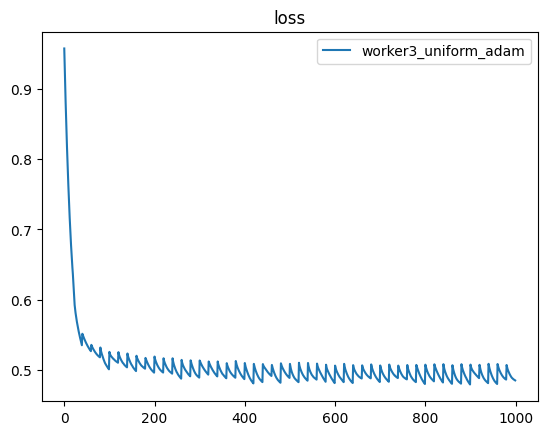

balanced_accuracy_score: 0.7914807302231237
accuracy_score: 0.8041958041958042
balanced_accuracy_score: 0.7624746450304261
accuracy_score: 0.7762237762237763
balanced_accuracy_score: 0.7424949290060852
accuracy_score: 0.7622377622377622
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


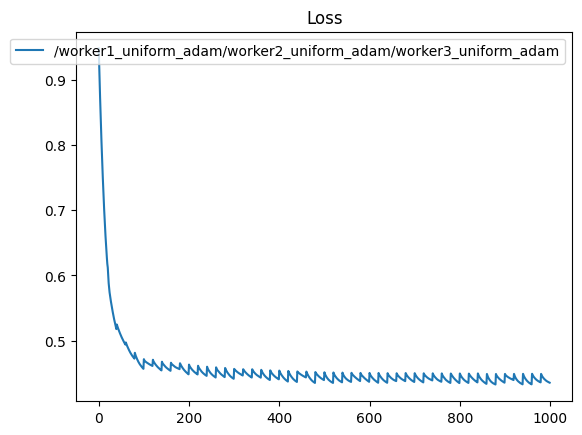

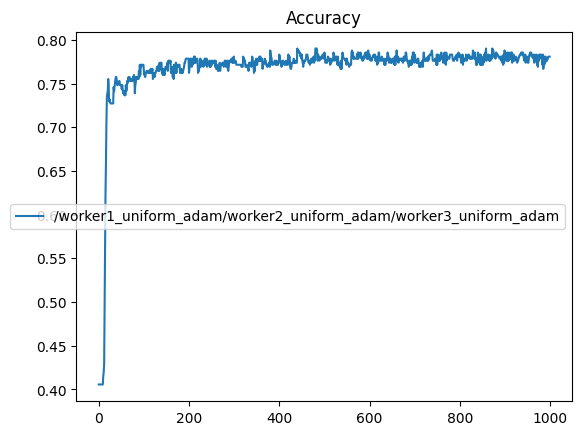

In [23]:
show_data_stat(federated_ua_stat_collectors)

#### сравнение: Scheduler: uniform,Scheduler: identical

worker1_ident_adam
balanced_accuracy_score: 0.7855983772819473
accuracy_score: 0.7972027972027972
worker2_ident_adam
balanced_accuracy_score: 0.7710953346855984
accuracy_score: 0.7832167832167832
worker3_ident_adam
balanced_accuracy_score: 0.7134888438133874
accuracy_score: 0.7342657342657343
worker1_uniform_adam
balanced_accuracy_score: 0.7914807302231237
accuracy_score: 0.8041958041958042
worker2_uniform_adam
balanced_accuracy_score: 0.7624746450304261
accuracy_score: 0.7762237762237763
worker3_uniform_adam
balanced_accuracy_score: 0.7424949290060852
accuracy_score: 0.7622377622377622


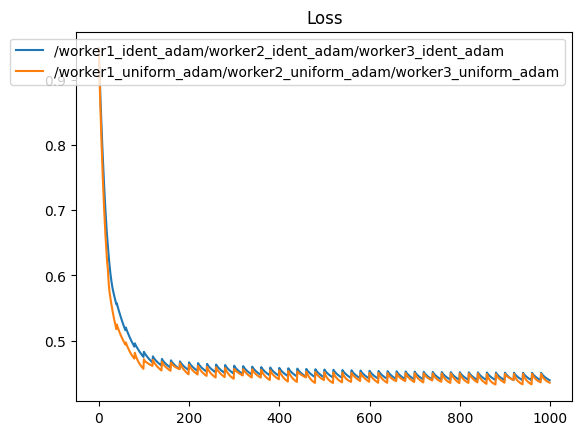

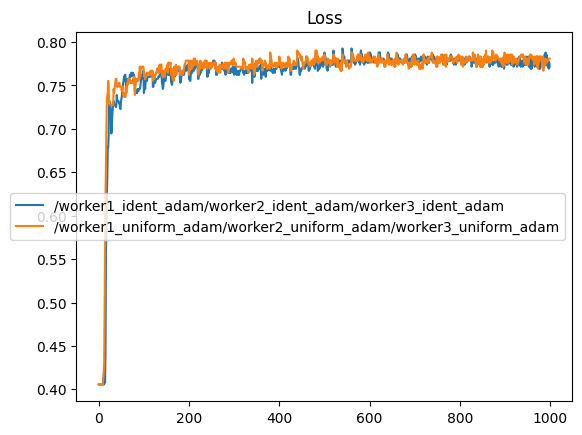

In [24]:
show_data_stat_comparison(federated_ia_stat_collectors,federated_ua_stat_collectors)

### Federated, preconditioner: OASIS

#### Scheduler: identity

In [25]:
#OASIS
model_params = {"lr":LR_EPOCH['lr']}

precond = [OASIS_preconditioner(beta2 = 0.2,alpha=1e-4),
           OASIS_preconditioner(beta2 = 0.2,alpha=1e-4),
           OASIS_preconditioner(beta2 = 0.2,alpha=1e-4)]

federated_io_stat_collectors = [Statistic(X_test,y_test,"worker1_ident_oasis"),
                                Statistic(X_test,y_test,"worker2_ident_oasis"),
                                Statistic(X_test,y_test,"worker3_ident_oasis")]

models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[0],
                                       epoch = 1,stat_collector=federated_io_stat_collectors[0]),
         Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[1],
                                       epoch = 1,stat_collector=federated_io_stat_collectors[1]),
         Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[2],
                                       epoch = 1,stat_collector=federated_io_stat_collectors[2])]

scheduler = [MatrixScheduler_identical(),MatrixScheduler_identical(),MatrixScheduler_identical()]

s = server(M_workers=3,
           X_train = X_train,y_train = y_train,
           stat_collectors = federated_io_stat_collectors,
           models = models,
           data_splitter = 'id',m_scheduler = scheduler)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

In [26]:
min(federated_io_stat_collectors[0].matrix_frequent),min(federated_io_stat_collectors[0].matrix_min),1e-4

(0.0001575551259593022, 9.1214052893793e-07, 0.0001)

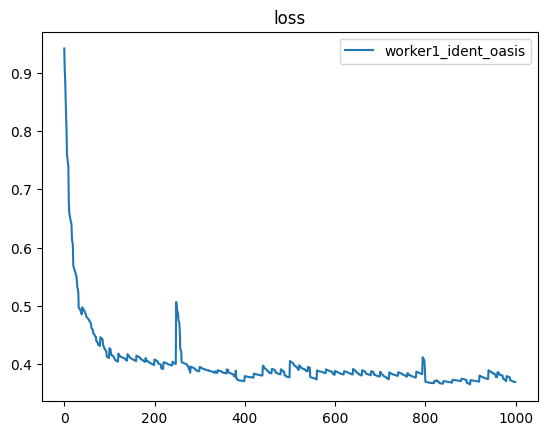

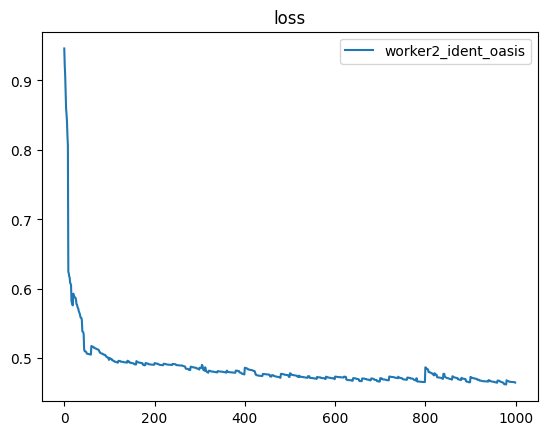

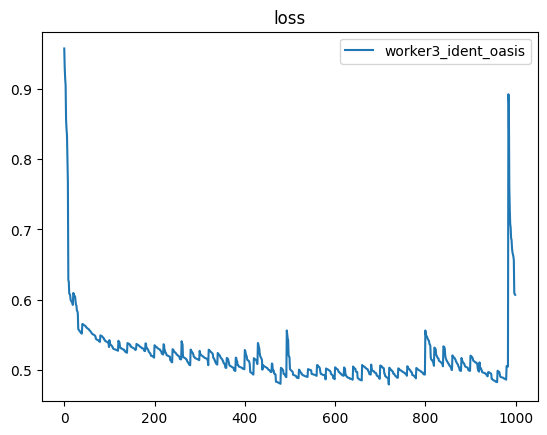

balanced_accuracy_score: 0.7797160243407708
accuracy_score: 0.7902097902097902
balanced_accuracy_score: 0.7942190669371196
accuracy_score: 0.8041958041958042
balanced_accuracy_score: 0.6504056795131846
accuracy_score: 0.6853146853146853
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


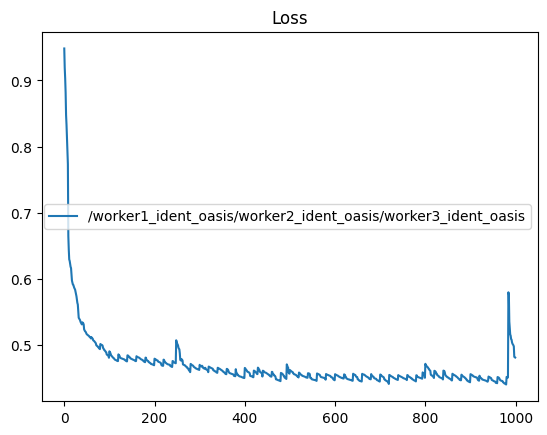

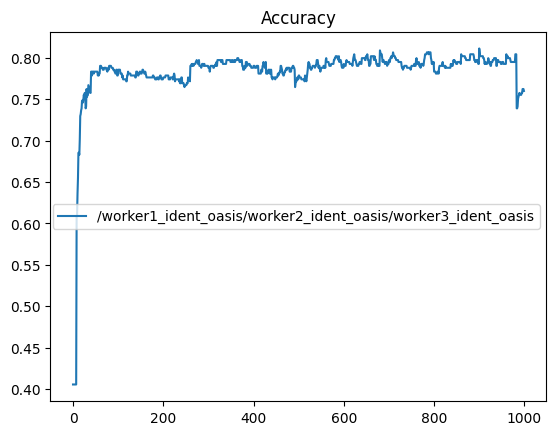

In [27]:
show_data_stat(federated_io_stat_collectors)

#### Scheduler: uniform

In [28]:
#OASIS
model_params = {"lr":LR_EPOCH['lr']}

precond = [OASIS_preconditioner(beta2 = 0.2,alpha=1e-4),
           OASIS_preconditioner(beta2 = 0.2,alpha=1e-4),
           OASIS_preconditioner(beta2 = 0.2,alpha=1e-4)]

federated_uo_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_oasis"),
                                Statistic(X_test,y_test,"worker2_uniform_oasis"),
                                Statistic(X_test,y_test,"worker3_uniform_oasis")]

models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[0],
                                       epoch = 1,stat_collector=federated_uo_stat_collectors[0]),
          Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[1],
                                       epoch = 1,stat_collector=federated_uo_stat_collectors[1]),
          Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                       lr = model_params['lr'], preconditioner = precond[2],
                                       epoch = 1,stat_collector=federated_uo_stat_collectors[2])]

scheduler = CommonMatrixScheduler_Uniform(alpha=0.01,gamma=3,
                                      change_mode=CommonMatrixScheduler_Uniform.change_on_each_global_update,n_workers = 3)

schedulers = [scheduler, scheduler, scheduler]

s = server(M_workers=3,
           X_train = X_train,y_train = y_train,
           stat_collectors = federated_uo_stat_collectors,
           models = models,
           data_splitter = 'id',m_scheduler = schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

In [29]:
min(federated_uo_stat_collectors[0].matrix_frequent),min(federated_uo_stat_collectors[0].matrix_min),1e-4

(0.00015192485633316877, 2.35675451850173e-06, 0.0001)

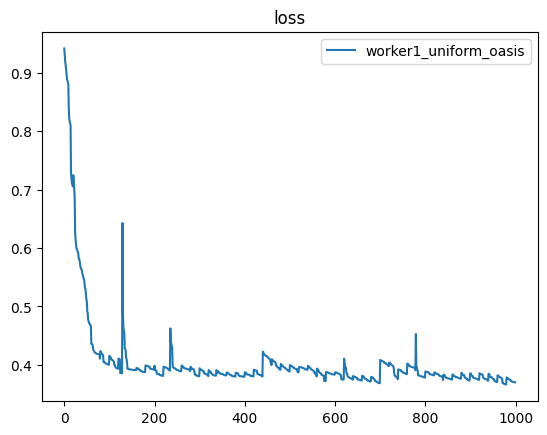

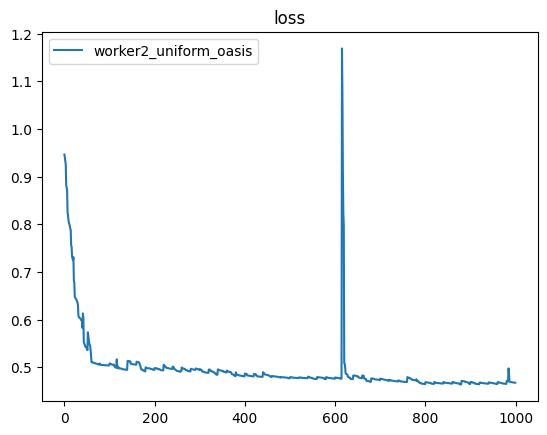

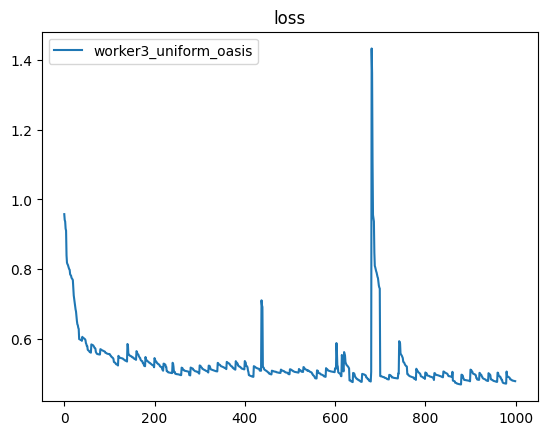

balanced_accuracy_score: 0.7738336713995944
accuracy_score: 0.7832167832167832
balanced_accuracy_score: 0.7855983772819473
accuracy_score: 0.7972027972027972
balanced_accuracy_score: 0.8001014198782961
accuracy_score: 0.8111888111888111
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


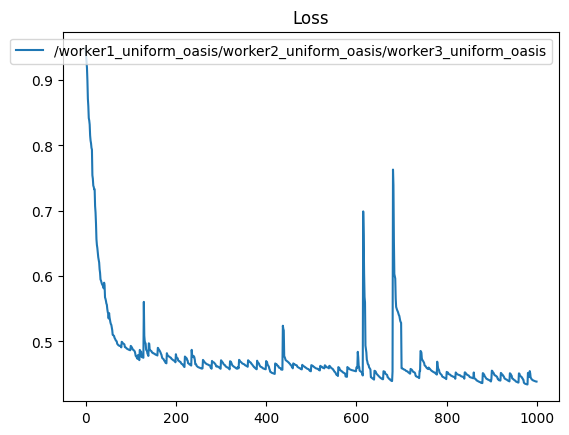

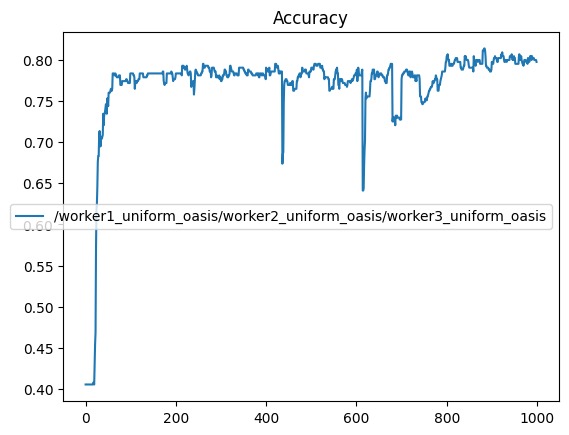

In [30]:
show_data_stat(federated_uo_stat_collectors)

#### сравнение: Scheduler: uniform,Scheduler: identical

worker1_ident_oasis
balanced_accuracy_score: 0.7797160243407708
accuracy_score: 0.7902097902097902
worker2_ident_oasis
balanced_accuracy_score: 0.7942190669371196
accuracy_score: 0.8041958041958042
worker3_ident_oasis
balanced_accuracy_score: 0.6504056795131846
accuracy_score: 0.6853146853146853
worker1_uniform_oasis
balanced_accuracy_score: 0.7738336713995944
accuracy_score: 0.7832167832167832
worker2_uniform_oasis
balanced_accuracy_score: 0.7855983772819473
accuracy_score: 0.7972027972027972
worker3_uniform_oasis
balanced_accuracy_score: 0.8001014198782961
accuracy_score: 0.8111888111888111


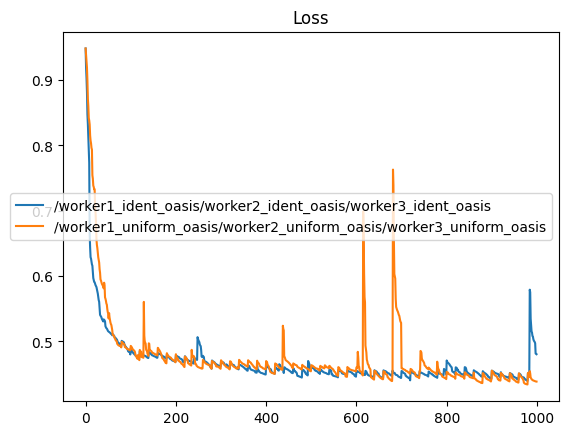

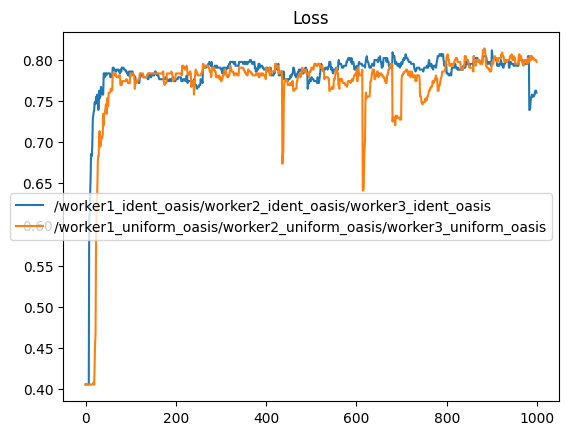

In [31]:
show_data_stat_comparison(federated_io_stat_collectors,federated_uo_stat_collectors)